In [1]:
using JuMP, Gurobi, Mosek, PyPlot

    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 0   1   6   7
           0   0   0   0]

mass = 1000 # in kg
g = 127008  #km/hr^2
maxacc = 500 # max acc in km/hr^2
maxv = 200 # max velocity in km/hr
maxTu = 1.27 #max steer one side

function solveOpt(λ)
    # m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(solver = MosekSolver(LOG=0))
    
    @variable(m, p[1:2,1:T[k]])
    @variable(m, 0 <= Thrust[1:T[k]] <= maxacc)
    ##Thrust cannot be negative so cant ecrease velocity
    ##ADDD FRICTION 
    
    @variable(m, 0 <= v[1:2,1:T[k]] <= maxv) 
    @variable(m, Acc[1:2,1:T[k]]) #Acc 1 is directional acc Acc2 is centipetal

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== 0)
#     @constraint(m, v[:,60] .== 0)
#     @constraint(m, Acc[2,:] == 0)
#     @constraint(m, p[:,T[1]] .== xw[:,1])
#     @constraint(m, p[:,T[2]] .== xw[:,2])

    for t in 1:T[k]-1
        @constraint(m, p[1,t+1] == p[1,t] + v[1,t])
#       @constraint(m, p[2,t+1] == p[2,t] + v[2,t])
        @constraint(m, v[1,t+1] == v[1,t] + Thrust[t])
        @constraint(m, v[2,t+1] == v[2,t] + Thrust[t])
    end
    
    # hit all the waypoints
    for i in 1:2
        @constraint(m, p[:,T[i]] .== xw[:,i])
    end
    
    
    # hit the first waypoint only
#     for i in 1
#         @constraint(m, p[:,T[i]] .== xw[:,1])
#     end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min,sum(Thrust.^2))# + λ*sum( (p[:,T]-xw).^2 ) )
    solve(m)
    
    J1 = getvalue(sum(Thrust.^2))
    J2 = getvalue(sum( (p[:,T]-xw).^2  ))
    xopt = getvalue(p)
    
    
    th = getvalue(Thrust)
    Vel = getvalue(v)
    for t in 1:T[k]
        println(t, ": Thrust = ", th[t], "| Velocity x= ", Vel[1,t], "| Velocity y= ", Vel[2,t])
    end
println(xopt[1,20], " : ", xopt[2,20])
figure(figsize=(12,4))
plot( th[2,:], "b.-", markersize=4 )
plot( Vel[2,:], "r-", markersize=12 )
plot( th[1,:], "m.-", markersize=4 )
plot( Vel[1,:], "g-", markersize=12 )
# axis("equal")
axis((1.,60.1,-.00005,.11));
    
    
    return (J1,J2,xopt)
end
;

1: Thrust = 0.008534836134931363| Velocity x= 0.0| Velocity y= 0.0
2: Thrust = 0.008060679566298079| Velocity x= 0.008534836134931362| Velocity y= 0.008534836134931362
3: Thrust = 0.007586523049529658| Velocity x= 0.01659551570122944| Velocity y= 0.01659551570122944
4: Thrust = 0.007112366597202001| Velocity x= 0.024182038752519622| Velocity y= 0.024182038752754768
5: Thrust = 0.006638210224997575| Velocity x= 0.031294405349721624| Velocity y= 0.03129440534995677
6: Thrust = 0.006164053953004185| Velocity x= 0.0379326155747192| Velocity y= 0.037932615574954344
7: Thrust = 0.005689897807632795| Velocity x= 0.044096669527723384| Velocity y= 0.04409666952795853
8: Thrust = 0.005215741824533832| Velocity x= 0.04978656733535618| Velocity y= 0.04978656733559132
9: Thrust = 0.004741586053177292| Velocity x= 0.05500230915989001| Velocity y= 0.055002309160125155
10: Thrust = 0.004267430564357646| Velocity x= 0.059743895213067305| Velocity y= 0.05974389521330245
11: Thrust = 0.003793275463309833

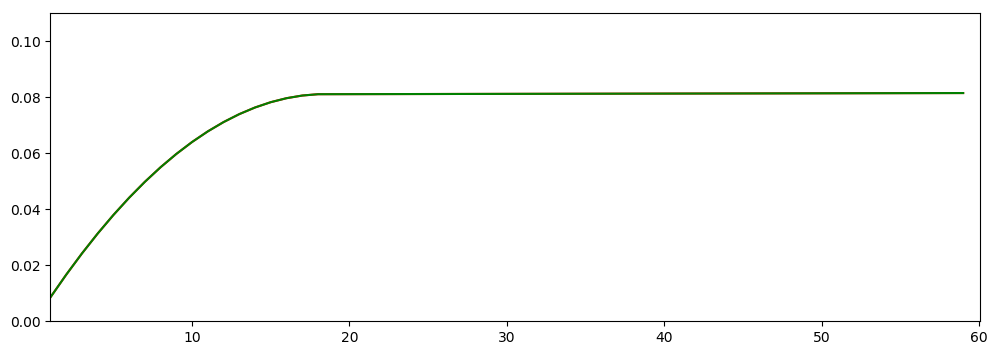

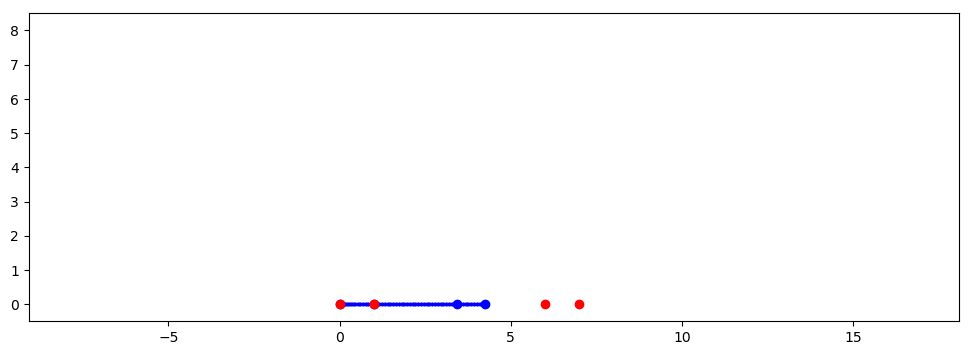

1.0 : -0.0


In [2]:
λ = 0.001
(J1x,J2x,x) = solveOpt(λ)

using PyPlot
figure(figsize=(12,4))
plot( x[1,:], x[2,:], "b.-", markersize=4 )
plot( x[1,:][T], x[2,:][T], "b.", markersize=12 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )
axis("equal")
axis((1.,8.,-.5,8.5));